In [701]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using Plots
using StatsBase

In [ ]:
"""
Game plan

Measurement function (1 hr)
- Function: compute pixel to meter mapping (x, y)
- Function: compute meter to pixel mapping (x, y)
- crop tiff to valid region (approximate) - plot certain range (from hardcoded origin value, then set range on meters
- Function: compute rgb to depth mapping (approximate - see charts)
- Create lookup - (x, y) to depth

Generate data (1 hr)
- inputs: xs, ys, thetas
- outputs: depth measurements

GOAL: output - thruster values, rudder values, xs, ys, thetas, depth measurements

Implement Particle filter
- given
    in_thruster
    in_rudder
- given initialization (put at map size/2)
- randomly generate particles around starting position (x, y, theta) - Note: use gaussians here. Use defined covariance
- plot initial particles


- compute likelihoods (2 hours)
    - generate gaussian around depth value with some defined variance
    - Convert difference to 0-1
- reweight particles
- resample particles from likelihoods, add noise to each (2 hours)
    - given array of likelihoods, sample index based on relative weight - generate n new points, based on weights
    - for each new point, add some noise
- average particle location = trajectory




Generate summary plot (1 hr)
- bathymetry
- ground truth trajectory
- computed trajectory



"""

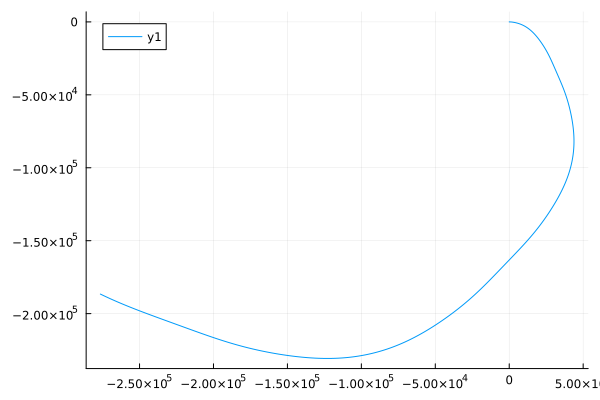

In [804]:
"""
Plan of action:

Generate trajectory - 

t = 0 to 1000, 100 steps

"""
function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

ts = range(0, stop=1000, length=1001)
# in_thruster = generate_data(ts, generate_random_func())
in_thruster = ones(size(ts))
in_rudder = 0.1*generate_data(ts, generate_random_func())

function simulate_trajectory(ts, in_thruster, in_rudder)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = 0 # X position
    ys[1] = 0 # Y position
    vs[1] = 0 # Velocity
    θs[1] = 0 # Heading
    dθs[1] = 0 # Angular Velocity
    
    # TODO: remove fixed timestamp
    dt = ts[2] - ts[1]
    
    for (i, t) in enumerate(ts[1:end-1])
        # Update position based on last timestep velocity
        xs[i+1] = xs[i] + dt*vs[i]*cos(θs[i])
        ys[i+1] = ys[i] + dt*vs[i]*sin(θs[i])
        θs[i+1] = θs[i] + dt*dθs[i]
        
        # Update velocities based on input
        vs[i+1] = vs[i] + in_thruster[i]*dt
        dθs[i+1] = dθs[i] + in_rudder[i]*dt
    end
    
    return xs, ys, θs, vs, dθs
end

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder)
plot(xs, ys)

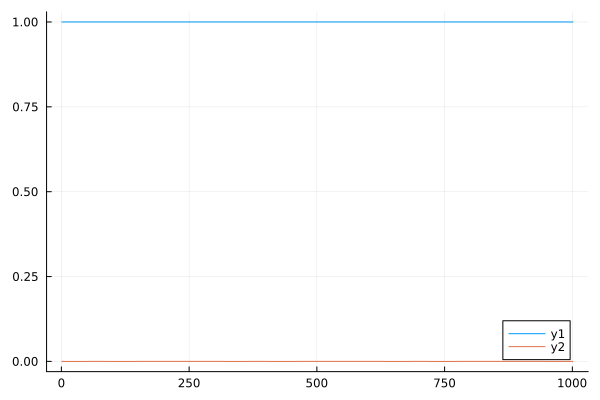

In [805]:
plot(in_thruster)
plot!(in_rudder)

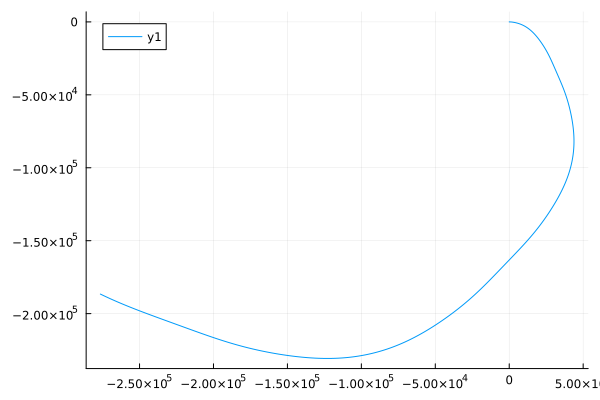

In [806]:
# plot(xs[1:100], ys[1:100])
plot(xs, ys)

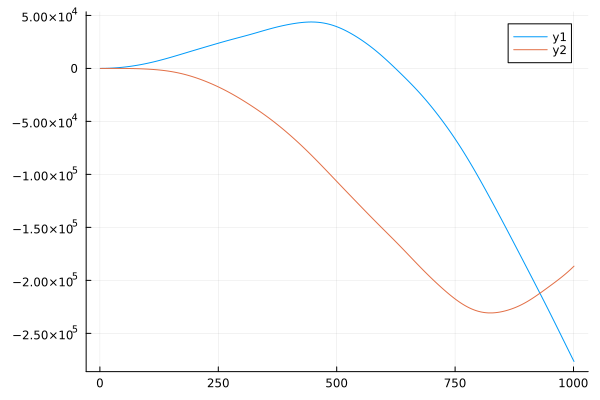

In [807]:
plot(xs)
plot!(ys)

## Measurement Model

In [808]:
# # using GDAL, GeoArrays
# using Images

# Open the GeoTIFF file
filename = "/home/amy/final_project_18337/PuertoRico_SouthWest_Color.tif"
img = load(filename)



# using GeoArrays

# filename = "/home/amy/final_project_18337/PuertoRico_SouthWest_Color.tif"
# geoarray = GeoArrays.read(filename)

# # # Define the latitude and longitude values
# # lat = 42.0
# # lon = -73.0

# # # Get the transformation matrix from geographic to pixel coordinates
# # geo_transform = dataset.geo_transform
# # inv_geo_transform = inv(geo_transform)

# # # Calculate the pixel coordinates for the given lat/lon values
# # pixel_coords = floor.(Int, inv_geo_transform * (lon, lat, 1))

# # # Look up the pixel value
# # band = dataset["Band_1"]
# # pixel_value = band[pixel_coords[2], pixel_coords[1]]

# # Close the dataset
# GDAL.close(dataset)

# using GDAL

# # Open the GeoTIFF file
# filename = "/home/amy/final_project_18337/PuertoRico_SouthWest_Color.tif"
# dataset = GDAL.Dataset(filename)

# Define a function to convert an RGB color to a value in the range of 0 to 30

function rgb_to_value(rgb_color::RGB{N0f8})
    # Interpolate between blue and red based on the green component
    green_component = green(rgb_color)
    value = 30-30 * (1 - green_component)

    # Return the value
    return value
end


rgb_to_value (generic function with 1 method)

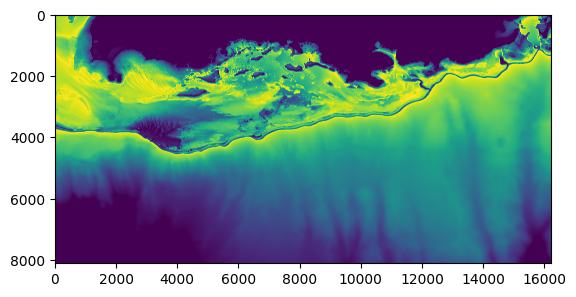

PyObject <matplotlib.image.AxesImage object at 0x7fe348335588>

In [809]:
# Apply the rgb_to_value function to the image
value_image = map(rgb_to_value, img)

# Display the value image
imshow(value_image)

In [810]:
size(value_image)


(8112, 16212)

In [811]:
# Convert from pixels to meters and vice versa

# ~40 miles, 16000px wide
# ~64000 meters

px_per_meter = 16000/64000

function px_to_meters(px)
    return px./px_per_meter
end

function meters_to_px(m)
    return m.*px_per_meter
end

function lookup_depth(x, y, map)
    # In meters
    # column, row (x, y) format. 0, 0 is top left of image
    
    # Find the pixel with the closest x, y values
    x_idx = argmin(abs.(collect(1:size(map, 2)) .- x))
    y_idx = argmin(abs.(collect(1:size(map, 1)) .- y))

    # Look up the pixel value
    pixel_value = map[y_idx, x_idx] 
    return pixel_value 
end

# px_to_meters([10,10,10])
# lookup_depth(1990,200,bathy_map) 
lookup_depth(1,1,bathy_map) 

20.82353f0

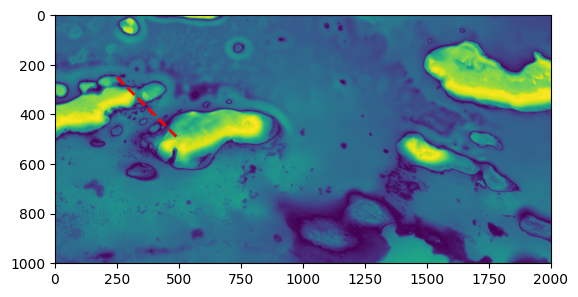

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe3482a1470>

In [812]:
bathy_map = value_image[1500:2500,6000:8000]

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)


# heatmap(bathy_map, aspect_ratio=:equal, color=:grays)
# plot!(600,600)
# plot!(x, y, color=:red, lw=2)
ax.plot([250,500],[250,500],"r--", lw=2)

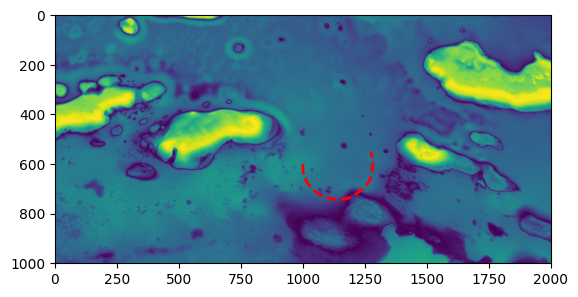

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe3481ddda0>

In [828]:
### REDOING WITH NEW STUFF
SIM_TIME = 1000 # s
N_STEPS = 1001

START_X = 1000 
START_Y = 600
START_θ = π/2

SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
MODEL_MEASUREMENT_STD = 10 # Modeled noise value

ts = range(0, stop=SIM_TIME, length=N_STEPS)
# in_thruster = generate_data(ts, generate_random_func())
in_thruster = 0.5*ones(size(ts))
in_rudder = 0.1*generate_data(ts, generate_random_func())

# TODO: remove fixed timestamp
DELTA_T = ts[2] - ts[1]

function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

function glider_dynamics_model(state, dt, in_thruster, in_rudder)
    x, y, θ, v, dθ = state
    
    # Update position based on state
    x_step = x + dt*v*cos(θ)
    y_step = y + dt*v*sin(θ)
    θ_step = θ + dt*dθ

    # Update velocities based on input
    v_step = v + dt*(in_thruster-v)
    dθ_step = dθ + dt*in_rudder

    return [x_step, y_step, θ_step, v_step, dθ_step]
end

function simulate_trajectory(ts, in_thruster, in_rudder; start_x=0, start_y=0, start_θ=0)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = start_x # X position
    ys[1] = start_y # Y position
    vs[1] = 0 # Velocity
    θs[1] = start_θ # Heading
    dθs[1] = 0 # Angular Velocity
    
    for (i, t) in enumerate(ts[1:end-1])
        state = (xs[i], ys[i], θs[i], vs[i], dθs[i])
        xs[i+1], ys[i+1], θs[i+1], vs[i+1], dθs[i+1] = 
            glider_dynamics_model(state, DELTA_T, in_thruster[i], in_rudder[i])
        
#         # Update position based on last timestep velocity
#         xs[i+1] = xs[i] + dt*vs[i]*cos(θs[i])
#         ys[i+1] = ys[i] + dt*vs[i]*sin(θs[i])
#         θs[i+1] = θs[i] + dt*dθs[i]
        
#         # Update velocities based on input
#         vs[i+1] = vs[i] + (in_thruster[i]-vs[i])*dt
#         dθs[i+1] = dθs[i] + in_rudder[i]*dt
    end
    
    return xs, ys, θs, vs, dθs
end

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
    start_x=START_X, start_y=START_Y, start_θ=START_θ)

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)

function simulate_measurements(xs, ys, map)
    # TODO: Add noise terms
    output = similar(xs)
    
    for (i, (x, y)) in enumerate(zip(xs, ys))
        output[i] = lookup_depth(x, y, map)
    end
    
    return output
end


# heatmap(bathy_map, aspect_ratio=:equal, color=:grays)
# plot!(600,600)
# plot!(x, y, color=:red, lw=2)
plot(xs, ys)

ax.plot(xs,ys,"r--", lw=2)

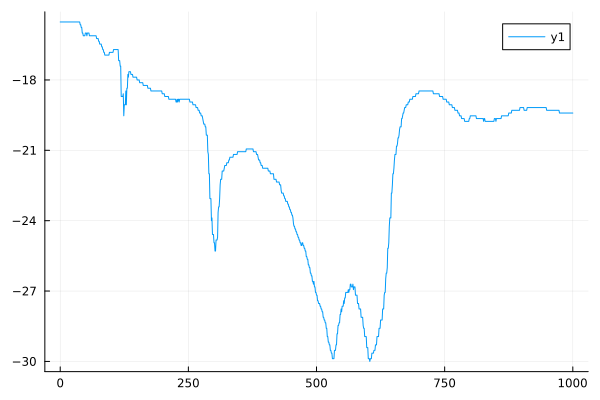

In [829]:
measurements = simulate_measurements(xs, ys, bathy_map)
plot(ts, -measurements)

## Particle Filter

In [830]:
function compute_likelihood(state, measurement, map)
    # State vector: x, y, θ, linear velocity, angular velocity
    x, y, θ, v, dθ = state

    model_depth = lookup_depth(x, y, map)

    dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
    pdf_value = pdf(dist, measurement)
    
#     println(model_depth)
#     println(pdf_value)
    return pdf_value
end


compute_likelihood (generic function with 3 methods)

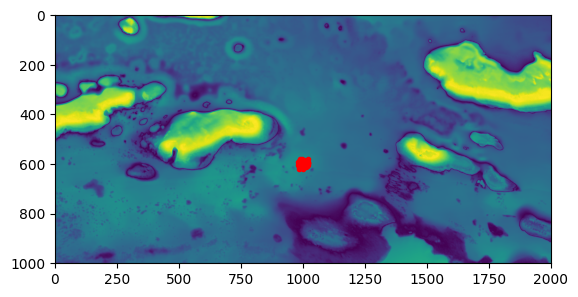

In [837]:
# Particle filter parameters
N_PARTICLES = 100
INIT_STD_POS = 10 # Positional standard deviation
INIT_STD_ROT = 0.1 # Rotational standard deviation (radians)

STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity

# INITIALIZATION ##############################################
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos = Normal(0, INIT_STD_POS)
dist_rot = Normal(0, INIT_STD_ROT)

for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos)
    y = START_Y + rand(dist_pos)
    θ = START_θ + rand(dist_rot)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

# Plot initial particles
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(particles[1,:], particles[2,:], "r.")


# PARTICLE FILTER ##############################################
state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
    # Update weights based on observation ---------------------
    # Compute relative likelihoods
    for (p_idx, p) in enumerate(eachcol(particles))
        weights[p_idx] = compute_likelihood(p, m, bathy_map)
    end   
    
    # Resample particles --------------------------------------
    # Normalize the weights
    w_norm = weights ./ sum(weights)

    # Generate N_PARTICLES samples
    samples = sample(1:size(particles, 2), Weights(w_norm), N_PARTICLES)

    # Extract the corresponding columns from the matrix
    new_particles = particles[:, samples]
    particles = new_particles
    
    # Update particles with dynamics model (build in noise term here)
    for (p_idx, p) in enumerate(eachcol(particles))
        particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
    end   
    
    # Update state estimate --------------------------------------
    state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly
end



# w = [1,1,1,2,3,4,5,6,7]

# idxs = sample(axes(b, 1), myweights, 10)

# INITIALIZATION

# SIM_TIME = 1000 # s
# N_STEPS = 1001

# START_X = 1000 
# START_Y = 600
# START_θ = π/2

# state_vec = 
# particles



# Implement Particle filter
# - given
#     in_thruster
#     in_rudder
# - given initialization (put at map size/2)
# - randomly generate particles around starting position (x, y, theta) - Note: use gaussians here. Use defined covariance
# - plot initial particles



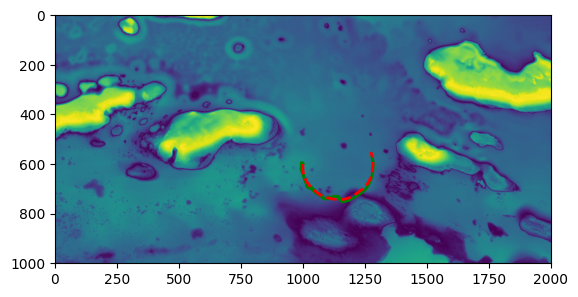

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe347e31a58>

In [843]:
# Plot result
fig, ax = PyPlot.subplots(figsize=[10])
ax.imshow(-bathy_map)
ax.plot(state_estimate[1,:], state_estimate[2,:], "g-", lw=2)
ax.plot(xs,ys,"r--", lw=2)

In [832]:
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# A = rand(5, 10)
# row_means = mean(A, dims=2)

In [833]:
mat = rand(3,10)
display(mat)
print(size([1,1,1,1,1,2,3,4,5,100]))
w = pweights([1,1,1,1,1,2,3,4,5,1000])

idxs = sample(axes(mat,2), w, 10)

3×10 Matrix{Float64}:
 0.81154   0.397788  0.583009  0.0229675  …  0.710262   0.952554  0.354428
 0.113621  0.640857  0.220384  0.828798      0.0781379  0.571905  0.107471
 0.936269  0.75525   0.196712  0.454966      0.747491   0.920674  0.861548

(10,)

10-element Vector{Int64}:
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10

In [834]:
# Example data
# mat = rand(3,10)
# w_unnormalized = [1,1,1,1,1,2,3,4,5,1000]
# p = w_unnormalized / sum(w_unnormalized)
# w = 1 ./ p
# w = w / sum(w)

# # Draw a sample from x using the weights in w
# sampled_index = sample(w_unnormalized, Weights(w), 1)

# Get the value of the sampled element from x
# sampled_value = x[1,sampled_index]



# RESAMPLE STEP #####################################


# Example data
mat = rand(3, 10)
w_unnormalized = [1, 1, 1, 1, 1, 2, 3, 4, 5, 1000]

# Normalize the weights
w = w_unnormalized ./ sum(w_unnormalized)

# Generate n samples
n = 5
samples = sample(1:size(mat, 2), Weights(w), n)

# Extract the corresponding columns from the matrix
sampled_mat = mat[:, samples]


3×5 Matrix{Float64}:
 0.834506   0.834506   0.834506   0.834506   0.834506
 0.0435393  0.0435393  0.0435393  0.0435393  0.0435393
 0.854841   0.854841   0.854841   0.854841   0.854841

In [722]:
axes(mat,2)

Base.OneTo(10)

In [700]:
# using StatsBase

# # Define an array of values
# x = [2, 3, 5, 2, 10]

# # Compute weights based on the relative values of the elements in x
# w = x ./ sum(x)

# # Sample an index from x based on the computed weights
# # idx = rand(SampleWeights(w))


LoadError: UndefVarError: SampleWeights not defined

In [548]:
# bathy_map[1,400]
# bathy_map[1,800]
# maximum(bathy_map)
# minimum(bathy_map)
# plot(bathy_map[:,1]) # column, row format. 0, 0 is top left of image



In [482]:
print(img[10,10000])

# function rgb_to_greyscale(rgb)
# end
# 0.2989, 0.5870, 0.1140.

# gray_value = Gray(img[10,10000])

# gray_img = Gray.(img)

# # Plot the grayscale image
# heatmap(gray_img, color=:grays)

# float(red(img[6000,10000]))

rgb_to_value(img[6000,10000])

RGB{N0f8}(1.0,0.0,0.0)

17.058825f0

In [457]:

# # affine_map = geotransform(geoarray)
# # plot(geoarray, band=3)
# # geoarray
# # 0.299red+0.587green+0.114blue
# # band_1 = geoarray[:,:,1]

# using GeoArrays

# # Load the GeoTIFF file into a GeoArray
# # filename = "path/to/geotiff/file.tif"
# # geoarray = GeoArrays.read(filename)

# # Define the latitude and longitude of the point of interest
# lat = 40.7128
# lon = -74.0060

# # Convert the latitude and longitude to row and column indices
# # setcrs!(geoarray, "+proj=longlat +datum=WGS84")
# # row, col = GeoArrays.coordinates(geoarray, lat, lon)

# # # Extract the RGB value at the specified location
# # rgb = geoarray[row, col, :]

# # # Convert the RGB value to depth
# # depth = 0.3048 * (rgb[1] + rgb[2] * 256 + rgb[3] * 65536)

# # # Print the depth value
# # println(depth)

LoadError: UndefVarError: __version__ not defined

In [420]:
# Define the x and y values
x = 100
y = 200

# Find the pixel with the closest x, y values
x_idx = argmin(abs.(collect(1:size(img, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(img, 1)) .- y))

# Look up the pixel value
pixel_value = img[y_idx, x_idx]
print(pixel_value)

RGB{N0f8}(0.69,0.882,0.0)

### Map Generation

In [212]:
using Plots
using CalculusWithJulia
import Contour: contours, levels, lines, coordinates
using LinearAlgebra, ForwardDiff

In [213]:
# Step 1
n = rand(5:20)

# Step 2
A = rand(-1:0.01:1, n)
B = rand(0.001:0.005:0.05, n)
f_rand(x,y) = sum(A[i]*sin.(B[i]*x) * A[i+1]*cos.(B[i+1]*y) for i in 1:n-1)


f_rand (generic function with 1 method)

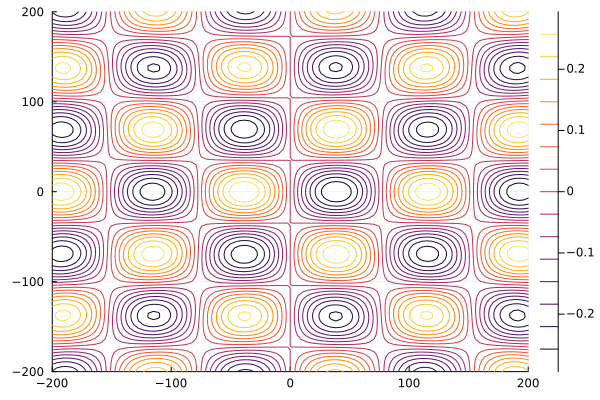

In [88]:
xs = range(-200, stop=200, length=100)
ys = range(-200, stop=200, length=100)
# f(x,y) = sin(x/100)*sin(y/100)
# f(x,y) = sin(x/100)*sin(y/100)
# surface(xs, ys, f)
contour(xs, ys, f_rand)

In [89]:
f_rand(xs, ys)

LoadError: MethodError: no method matching *(::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  *([91m::StridedMatrix{T}[39m, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at ~/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/matmul.jl:49
[0m  *(::StridedVecOrMat, [91m::Adjoint{<:Any, <:LinearAlgebra.LQPackedQ}[39m) at ~/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/lq.jl:269
[0m  ...

In [40]:
using PyPlot

[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
┌ Warning: Module Conda with build ID 2670194404143 is missing from the cache.
│ This may mean Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
┌ Warning: Module Conda with build ID 2670194404143 is missing from the cache.
│ This may mean Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __precompile__(false). Importing PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee].
[ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
┌ Warning: Module Conda with build ID 2670194404143 is missing from the cache.
│ This may mean Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1325
[ Info: Skipping precompilation since __

In [21]:
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

### Lookup values

In [ ]:
function simulate_measurement(x,y,theta,noise=0)
    # TODO: Returns beam 1, 2, 3, 4
    return f_rand(x, y)
end

In [ ]:
# End goal: plot of real trajectory, 
# versus computed one with particle filter